In [212]:
import os, json, tqdm, time, sys
sys.path.append('../')
from umap import UMAP
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from src.model.modules import SingleEncoderModel
from src.utils.visualization import plot_scatter

## generate data over chemical space

- dataframe

In [52]:
df = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_221123.csv')
col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']
#df = df[~df['TG'].isna()]
wdf = df[col_w].fillna(0)
wmasks = []
for x in 'ABCDE':
    wmasks.append(df.loc[wdf[f'FR_{x}'] == 0, 'ID'].values)
    print(x, len(wmasks[-1]))
    
smiles_e = df.SMILES_E[df.FR_E != 0]
for s in smiles_e.drop_duplicates():
    for x in 'ABCDE':
        m = df[f'FR_{x}'] != 0
        print(x, s, np.sum(df.loc[m, f'SMILES_{x}'] == s))

smiles_all = np.sort(np.unique(df[col_s].values.reshape(-1)))
smiles_f = [s for s in smiles_all if 'F' in s]
smiles_ue = smiles_e.drop_duplicates().values
smiles_c = [s for s in smiles_all if 'F' not in s and s not in smiles_ue]

A 61
B 88
C 106
D 161
E 38
A CC(=C)C(=O)OCCO 0
B CC(=C)C(=O)OCCO 0
C CC(=C)C(=O)OCCO 0
D CC(=C)C(=O)OCCO 0
E CC(=C)C(=O)OCCO 282
A OCCOC(=O)C=C 0
B OCCOC(=O)C=C 0
C OCCOC(=O)C=C 0
D OCCOC(=O)C=C 0
E OCCOC(=O)C=C 7
A CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
B CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 4
C CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
D CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
E CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 35


- test iteration

In [15]:
interval = 2
e = 2
for a in range(interval, 10-e+interval, interval):
    k = 10 - a - e
    for b in range(interval, k+1, interval):
        for c in range(interval, k-b, interval):
            d = k-b-c
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
            
    print('-'*20)
    zerocase = [np.array(l.replace('0_','').split('_'), dtype=int) for l in np.unique(['{}_{}'.format(*sorted((x, y))) for x in range(0, k+1, interval) for y in range(0, k+1, interval) if x+y == k])]
    for zc in zerocase:
        if len(zc) == 1:
            b = zc[0]
            c, d = 0, 0
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
        else:
            b, c = zc
            d = 0
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
    print('='*20)



2 | 2  2  2 | 2  / 10
--------------------
2 | 6  0  0 | 2  / 10
2 | 2  4  0 | 2  / 10
--------------------
4 | 4  0  0 | 2  / 10
4 | 2  2  0 | 2  / 10
--------------------
6 | 2  0  0 | 2  / 10
--------------------
8 | 0  0  0 | 2  / 10


- generate

In [57]:
pbar = tqdm.tqdm(total=len(smiles_f))
data = {'SMILES_A':[], 'SMILES_B':[], 'SMILES_C':[], 'SMILES_D':[], 'FR_A':[], 'FR_B':[], 'FR_C':[], 'FR_D':[]}
def append_data(data, sa, fra, sb='', frb=0, sc='', frc=0, sd='', frd=0):
    data['SMILES_A'].append(sa)
    data['FR_A'].append(fra)
    data['SMILES_B'].append(sb)
    data['FR_B'].append(frb)
    data['SMILES_C'].append(sc)
    data['FR_C'].append(frc)
    data['SMILES_D'].append(sd)
    data['FR_D'].append(frd)
    return data

interval = 2
e = 2
n = 0
nc = len(smiles_c)

for ia, sa in enumerate(smiles_f):
    data = append_data(data, sa, 1 - e/10)
    pbar.update(1)
    for a in range(interval, 10-e+interval, interval):
        k = 10 - a - e
        for b in range(interval, k+1, interval):
            for ib in range(nc):
                for c in range(interval, k-b, interval):
                    d = k - b - c
                    for ic in range(ib+1, nc):
                        for id in range(ic+1, nc):
                            data = append_data(data, sa, a/10, smiles_c[ib], b/10, smiles_c[ic], c/10, smiles_c[id], d/10)
        zerocase = [np.array(l.replace('0_','').split('_'), dtype=int) for l in np.unique(['{}_{}'.format(*sorted((x, y))) for x in range(0, k+1, interval) for y in range(0, k+1, interval) if x+y == k])]
        for zc in zerocase:
            for ib in range(nc):
                if len(zc) == 1:
                    data = append_data(data, sa, a/10, smiles_c[ib], zc[0]/10)
                else:
                    for ic in range(nc):
                        if ib == ic: continue
                        if zc[0] == zc[1] and ib > ic: continue
                        data = append_data(data, sa, a/10, smiles_c[ib], zc[0]/10, smiles_c[ic], zc[1]/10)
df2 = pd.DataFrame(data)
df2['SMILES_E'] = smiles_ue[0]
df2['FR_E'] = 0.2
df2['ID'] = df2.index
df2 = df2[['ID'] + [f'SMILES_{x}' for x in 'ABCDE'] + [f'FR_{x}' for x in 'ABCDE']]
#df2.to_csv('./data/chem_20231108_0.2.csv', index=False)

100%|██████████| 22/22 [00:35<00:00,  1.62s/it]


In [585]:
dfs = pd.read_csv('./data/chem_20230803_0.2.csv')
dfs.shape[0]

9880.0

In [578]:
col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_f = [f'FR_{x}' for x in 'ABCDE']
smiles_all_s = np.unique(dfs[col_s].fillna('').values)

In [581]:
smiles_all.shape, smiles_all_s.shape
np.array([s for s in smiles_all_s if 'F' in s])

(22,)

# screening

In [18]:

import torch, gc, os, json, pickle, tqdm, time, sys
sys.path.append('../')
from src.model.modules import SingleEncoderModel
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation, DataScaler
from src.utils.trainer import Trainer
from src.utils.visualization import plot_scatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

device = 'cuda'
sdf = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv')
sdf.shape

(201850, 11)

### by embedding vectors - exploring unknown data

- get data

In [19]:
sdf = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv')
device = 'cpu'
train_data = FPolyDatasetV2()
test_data = FPolyDatasetV2()
screen_data = FPolyDatasetV2()
train_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                    col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='TG')
test_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                   col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='TG')
screen_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                    col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='ID')

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : 

- get embedding

In [20]:
train_feat, train_target, _ = collate_fn(train_data, device=device)
test_feat, test_target, _ = collate_fn(test_data, device=device)
train_target = train_target.cpu().numpy().squeeze()
test_target = test_target.cpu().numpy().squeeze()

dls = {
    'train' : DataLoader(train_data, batch_size=4096, collate_fn=collate_fn),
    'test'  : DataLoader(test_data, batch_size=4096, collate_fn=collate_fn),
    'screen': DataLoader(screen_data, batch_size=4096, collate_fn=collate_fn),
}
train_data.to(device)
test_data.to(device)
screen_data.to(device)

if os.path.isfile('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl'):
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl','rb') as f:
        preds, embeds = pickle.load(f)
else:
    preds  = {i:{dl_name:[] for dl_name in dls.keys()} for i in range(5)}
    embeds = {i:{dl_name:[] for dl_name in dls.keys()} for i in range(5)}
    scaler = DataScaler(device)
    for i in range(5):
        path = '../outputs/models/finetune/all_ens'
        model = SingleEncoderModel(**json.load(open(os.path.join(path, f'fold_{i}/param.json'))))
        model.load(os.path.join(path, f'fold_{i}/model.torch'), rebuild_model=True)
        model.eval()
        model.to(device)
        scaler.load(path)
        tr = Trainer(model, None, scaler=scaler)
        with torch.no_grad():
            for dl_name, dl in dls.items():
                for batch in dl:
                    p = model(batch[0])
                    e = model._embd
                    preds[i][dl_name].append(scaler.restore(p).cpu().numpy().astype(float))
                    embeds[i][dl_name].append(e.cpu().numpy().astype(float))
                preds[i][dl_name] = np.vstack(preds[i][dl_name]).squeeze()
                embeds[i][dl_name] = np.vstack(embeds[i][dl_name]).squeeze()
        with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl','wb') as f:
            pickle.dump([preds, embeds], f)

- get manifold

In [22]:
n1, n2, n3 = [v.shape[0] for v in embeds[0].values()]
n2 = n1 + n2
if os.path.isfile('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl'):
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl','rb') as f:
        tvecs = pickle.load(f)
else:
    tvecs = {}
#    for i in range(5):
#        tsne = TSNE(random_state=100)
#        tvecs[i] = tsne.fit_transform(np.vstack([e for e in embeds[i].values()]))
    tsne = TSNE(random_state=10)    
    tvecs['a'] = tsne.fit_transform(np.hstack([np.vstack([e for e in embeds[i].values()]) for i in range(5)]))
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl','wb') as f:
        pickle.dump(tvecs, f)

- plot with predicted temperature

(-150.0, 150.0)

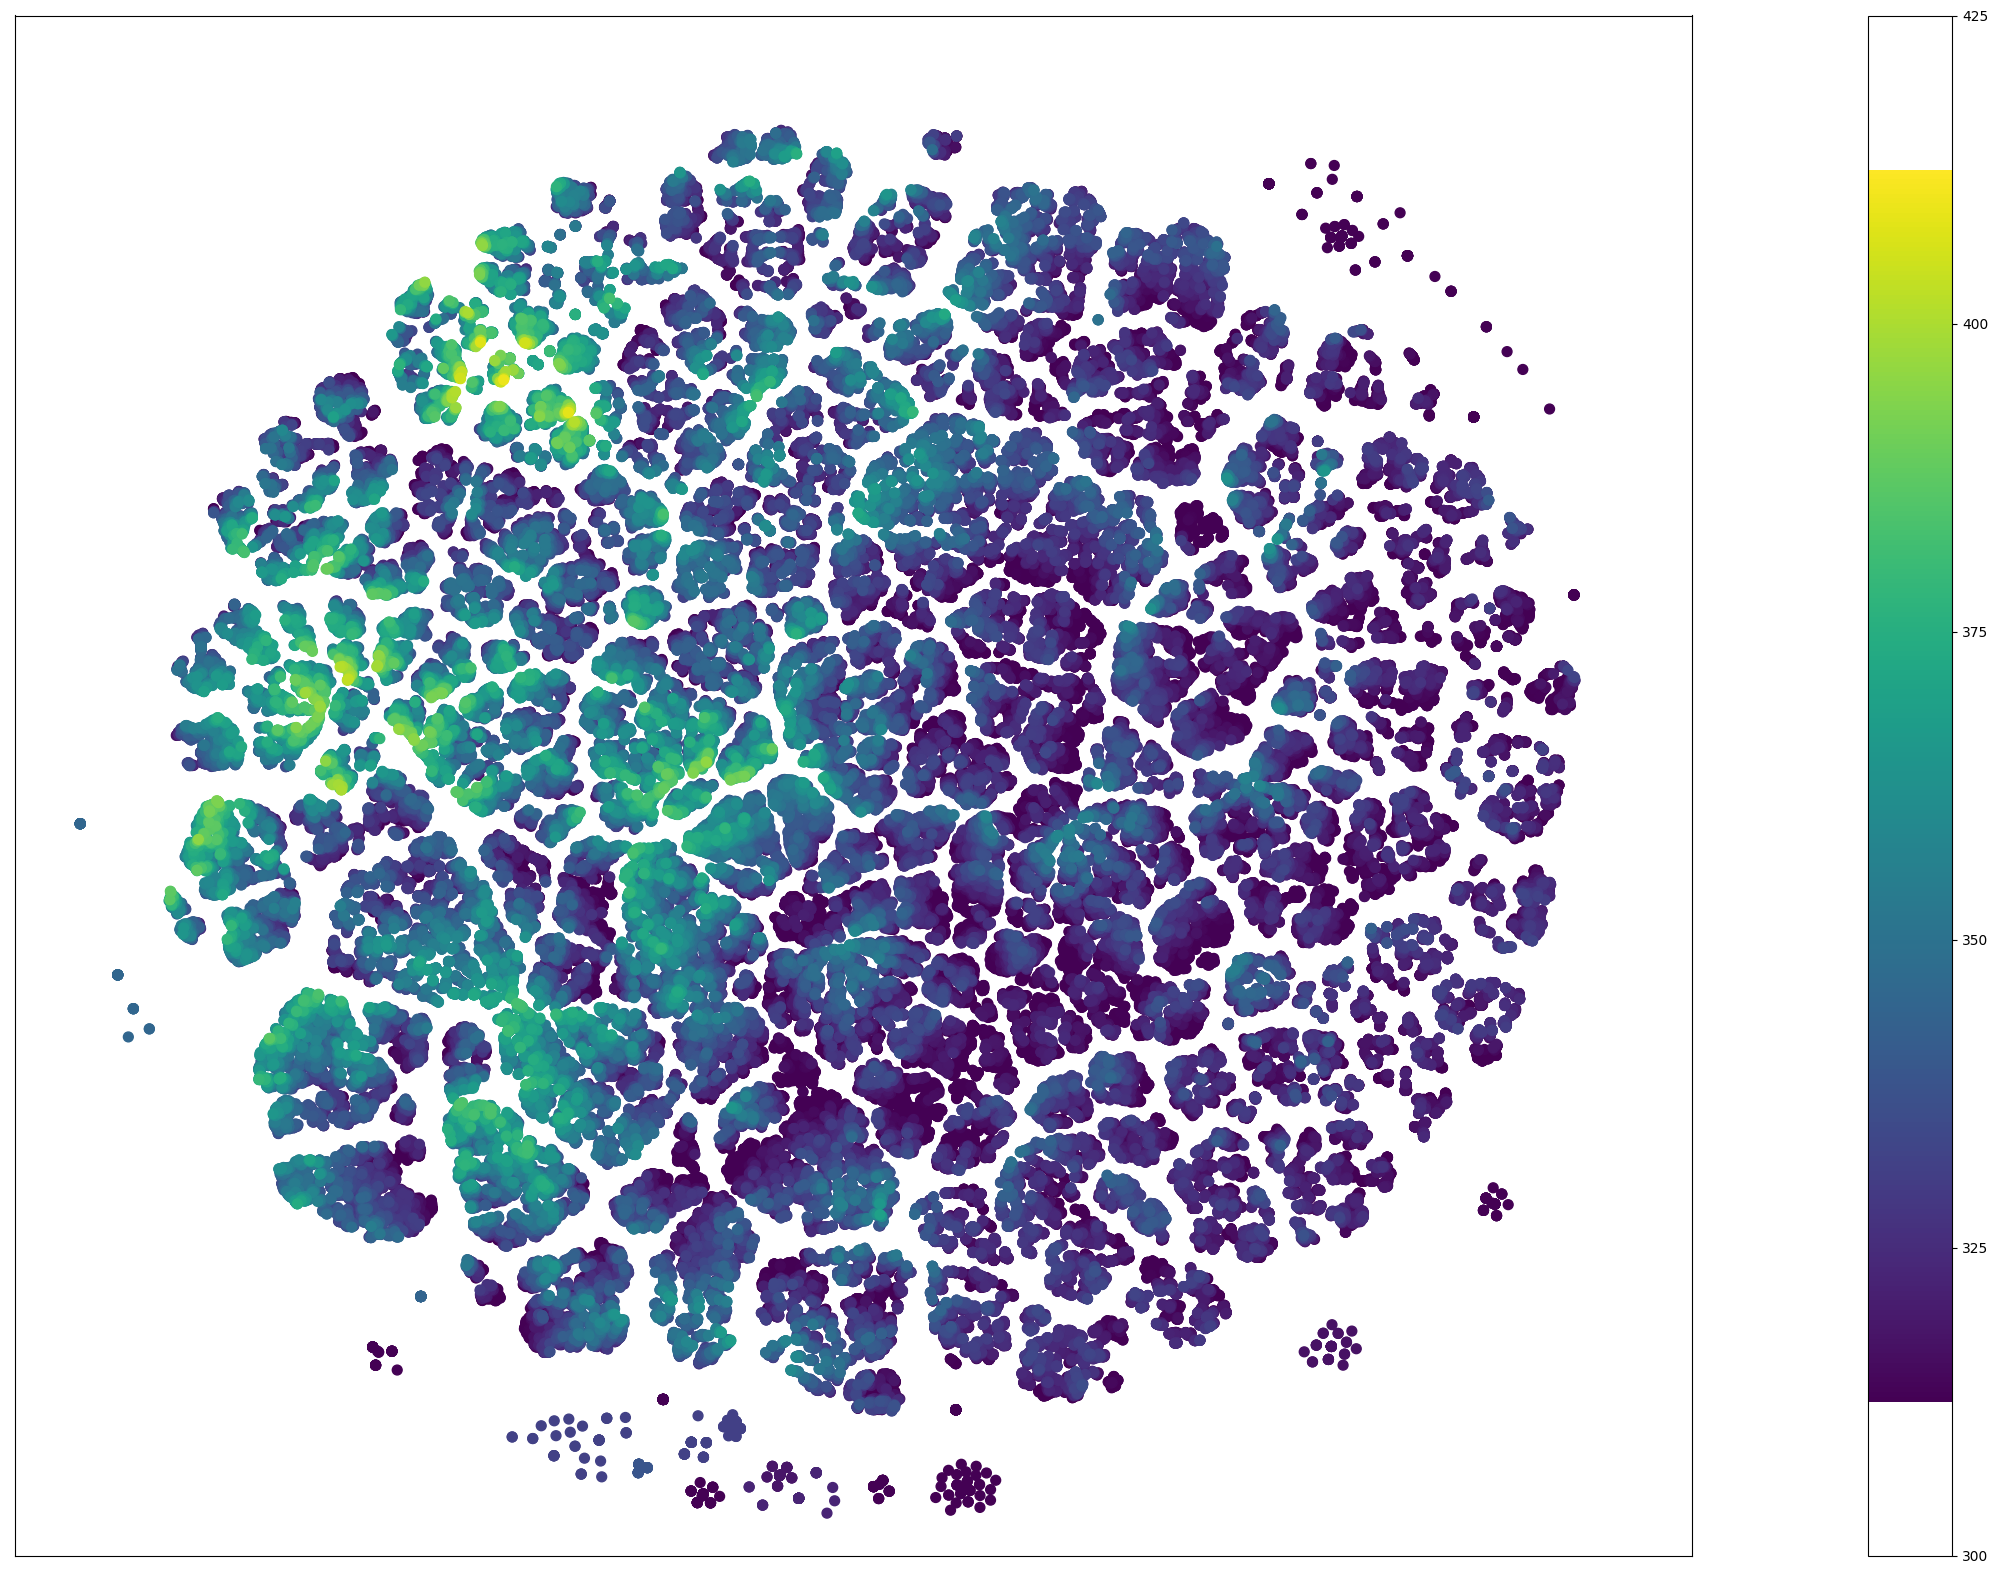

In [23]:
tval = np.mean([preds[i]['screen'].squeeze() for i in range(5)], 0) + 273.15
f, axs = plt.subplots(1,2,figsize=(25, 20), gridspec_kw={'width_ratios':[1, 0.05]})
axs[0].set_xticks([])
axs[0].set_yticks([])
otvec = tvecs['a'][:n2]
stvec = tvecs['a'][n2:]
#axs[0].scatter(*otvec[:n1].T, s=150, marker='D', edgecolor=[0,0,0], zorder=88, color=mpl.cm.tab10(5))
#axs[0].scatter(*otvec[n1:].T, s=150, marker='s', edgecolor=[0,0,0], zorder=88, color=mpl.cm.tab10(1))
#im = axs[0].scatter(*stvec[np.argsort(tval)][-200:].T, c=tval[np.argsort(tval)][-200:], s=10, cmap=mpl.cm.magma, vmin=300, vmax=500)
im = axs[0].scatter(*stvec[np.argsort(tval)].T, c=tval[np.argsort(tval)], s=50, cmap=mpl.cm.viridis, vmin=312.5, vmax=412.5)
plt.colorbar(im, cax=axs[1])
axs[1].set_yticks([300+25*i for i in range(6)])
#f.savefig('output.screen.manifold.pdf')
axs[0].set_xlim([-150,150])
axs[0].set_ylim([-150,150])
#f.savefig('./figs/output.manifold.screen.png')
#f.savefig('./figs/output.manifold.data.pdf')

(380.0, 440.0)

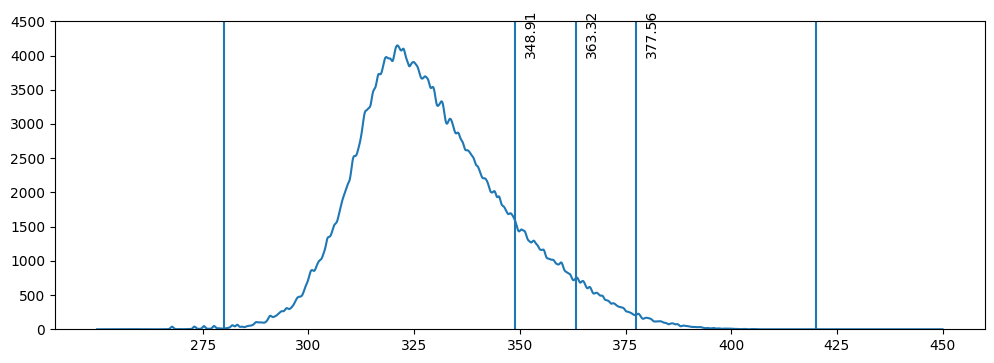

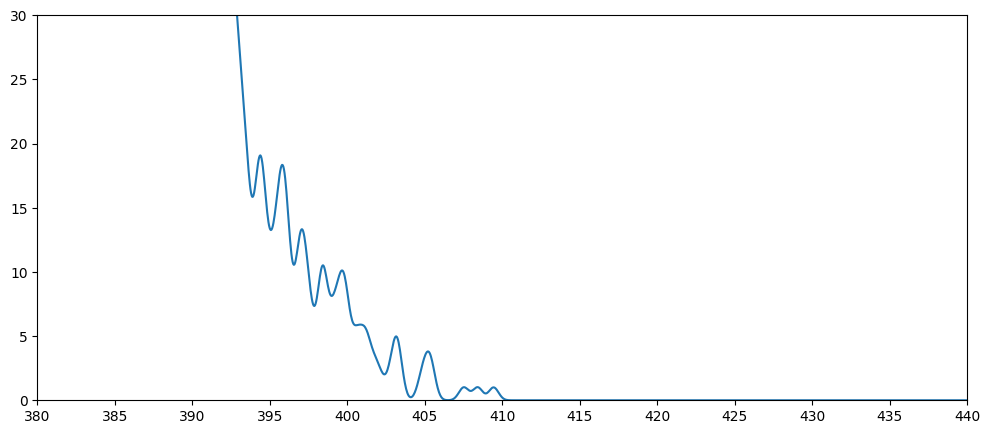

In [25]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

tval = np.mean([preds[i]['screen'] for i in range(5)], 0) + 273.15
g1 = gaussian_kernel(tval, 0.2)

f, ax = plt.subplots(1,1,figsize=(12, 4))
x = np.linspace(250, 450, 5000)
y = g1(x)
y[y < 1e-3] = 0
_ = ax.plot(x, y)

for v in np.quantile(tval, [0.85, 0.95, 0.99]):
    ax.axvline(v)
    ax.text(v+2, 4000, f'{v:.2f}', rotation=90)
ax.set_xticks([275 + 25*i for i in range(8)])
ax.axvline(280)
ax.axvline(420)
ax.set_ylim([0,4500])
#f.savefig('./figs/output.screen.distribution.pdf')

f, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(x,y)
ax.set_xticks([375 + 5*i for i in range(15)])
ax.set_ylim([0,30])
ax.set_xlim([380, 440])
#f.savefig('./figs/output.screen.distribution.inset.pdf')

In [ ]:
result_df = sdf.copy()
result_df['TG'] = tval
result_df.to_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv', index=False)

## results analysis

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from rdkit import Chem
from rdkit.Chem import Descriptors

col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']

df_screen = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv').fillna('')
df_train = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
df_test = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
df_train.TG = df_train.TG + 273.15
for i, row in df_train.iterrows():
    df_train.loc[i, col_w] = row[col_w].values / row[col_w].sum()
    ss = row[col_s]
    ss.values[row[col_w] == 0] = ''
    df_train.loc[i, col_s] = ss
smiles = sorted(np.unique(df_screen[col_s].values.reshape(-1)))
mol_ws = {s:Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles}

In [66]:
ssf_380, csf_380 = np.unique(df_screen[df_screen.TG > 380].SMILES_A, return_counts=True)
o = np.argsort(csf_380)[::-1]
ssf_380, csf_380 = ssf_380[o], csf_380[o]
ssf_390, csf_390 = np.unique(df_screen[df_screen.TG > 390].SMILES_A, return_counts=True)
o = np.argsort(csf_390)[::-1]
ssf_390, csf_390 = ssf_390[o], csf_390[o]
ssf_400, csf_400 = np.unique(df_screen[df_screen.TG > 400].SMILES_A, return_counts=True)
o = np.argsort(csf_400)[::-1]
ssf_400, csf_400 = ssf_400[o], csf_400[o]

In [70]:
ss_390, cs_390 = np.unique(df_screen.loc[df_screen.TG > 390, col_s].values.reshape(-1), return_counts=True)
o = np.argsort(cs_390)[::-1]
ss_390, cs_390 = ss_390[o], cs_390[o]

In [68]:
(df_screen.TG > 390).sum(), df_screen.shape

(274, (201850, 12))

In [75]:
for s, c in zip(ss_390, cs_390):
#    if 'F' in s: continue
    if 'F' not in s: continue
    if s == '': continue
    m_sta = (df_train[col_s].values == s).sum(1) != 0
#    if np.sum(m_sea) + np.sum(m_sta) != 0:
    print(c, '  /  ', s)
    v2 = df_train.loc[m_sta, 'TG'].values
    if m_sta.sum() == 0:
        print('train :   0')
    else:
        print('train : {:3d} / {:8.3f} / {:8.3f} / {:8.3f} / {:8.3f}'.format(m_sta.sum(), v2.min(), v2.max(), v2.mean(), v2.std()))
        print('  '.join([f'{v:.2f}' for v in sorted(v2)]))
    print('-'*50)
    

107   /   C=C(C(=O)O)C(F)(F)F
train :   0
--------------------------------------------------
57   /   CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
train :  12 /  306.550 /  415.580 /  349.938 /   35.007
306.55  309.65  315.95  316.35  332.29  349.63  351.13  354.14  360.79  380.43  406.77  415.58
--------------------------------------------------
34   /   CC(=C)C(=O)OCC(F)(F)F
train :   7 /  305.050 /  361.180 /  347.089 /   17.942
305.05  345.34  347.94  354.64  357.55  357.92  361.18
--------------------------------------------------
27   /   CC(=C)C(=O)OCC(C(F)(F)F)(F)F
train :  50 /  310.050 /  405.550 /  355.894 /   23.742
310.05  315.04  315.70  318.77  318.80  320.16  327.63  330.50  331.91  333.46  336.48  336.80  339.19  340.35  341.88  342.73  342.96  344.59  345.06  348.08  348.59  350.81  350.83  351.45  353.05  354.14  357.90  357.92  359.81  366.08  367.10  369.63  372.03  372.69  373.61  373.65  373.67  373.99  375.42  376.36  376.50  376.85  380.58  380.66  383.37  384.69  393.66  3

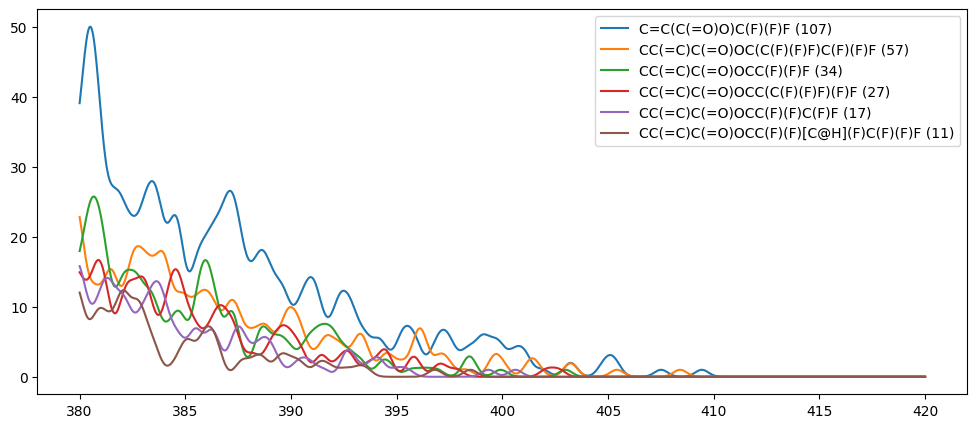

In [244]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

f, ax = plt.subplots(1,1,figsize=(12, 5))
for s, c in zip(ss_390, cs_390):
    if 'F' not in s : continue
    if c < 10: break
    val = df_screen.TG.values[(df_screen[col_s] == s).values.sum(1) != 0]
    g1 = gaussian_kernel(val, 0.2)
    x = np.linspace(380, 420, 1000)
    y = g1(x)
    y[y < 1e-3] = 0
    ax.plot(x, y, label=f'{s} ({c})')
ax.legend(loc='upper right')

In [4]:
train_list = {make_key(r):None for i,r in df3.iterrows()}
test_list = {make_key(r):None for i,r in df4.iterrows()}
exp_list = {make_key(r):None for i,r in df1_part.iterrows()}

In [10]:
df1_part = df1.iloc[32:53].copy()
df1_part.loc[:,'S_A'] = [''] * df1_part.shape[0]

In [5]:
train_list = {}
for i,r in df3.iterrows():
    k = make_key(r)
    if k in train_list:
        train_list[k].append(i)
        print(i, k, train_list[k])
    else:
        train_list[k] = [i]


97 c10:0.20_c15:0.20_c20:0.10_c34:0.30_f04:0.19 [96, 97]
170 c05:0.40_c15:0.20_c34:0.40 [164, 170]
232 c00:0.10_c15:0.20_c34:0.40_f17:0.30 [230, 232]


In [11]:
df3.loc[[96, 97, 164, 170, 230, 232]]

,ID,Name,CAS_A,CAS_B,CAS_C,CAS_D,CAS_E,SMILES_A,SMILES_B,SMILES_C,...,FR_A,FR_B,FR_C,FR_D,FR_E,ES,DC,TG,MW,TGA_0.01
96,FA-00277,0184_HxFIPMA-AMMA-t2,3063-94-3,16887-36-8,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F,CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2,COC(=O)C(C)=C,...,19.0,20.2,30.4,10.1,20.2,NaN,1.33,142.43,62292.0,187.82
97,FA-00278,0185_HxFIPMA-AMMA-t3,3063-94-3,16887-36-8,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F,CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2,COC(=O)C(C)=C,...,19.0,20.2,30.4,10.1,20.2,NaN,1.97,117.12,68858.0,181.75
164,FA-00372,174_PHEA-442,45115-53-5,48145-04-6,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,C=CC(=O)OCCOc1ccccc1,COC(=O)C(C)=C,...,NaN,4.0,4.0,NaN,2.0,NaN,1.95,44.35,53116.0,267.92
170,FA-00380,182_EGPEA-442,45115-53-5,48145-04-6,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,C=CC(=O)OCCOc1ccccc1,COC(=O)C(C)=C,...,NaN,4.0,4.0,NaN,2.0,NaN,1.85,33.70,94960.0,226.05
230,FA-00465,314_NFA3-MMA4-AA1,52591-27-2,32360-05-7,80-62-6,1979-10-07,868-77-9,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,COC(=O)C(C)=C,...,3.0,0.0,4.0,1.0,2.0,NaN,3.34,65.22,37302.0,253.19
232,FA-00467,316_PF3-MMA4-AA1,52591-27-2,32360-05-7,80-62-6,1979-10-07,868-77-9,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,COC(=O)C(C)=C,...,3.0,0.0,4.0,1.0,2.0,NaN,2.90,84.70,30523.0,181.64


In [9]:
for i, ri in df3.iterrows():
    ki = make_key(ri)
    for j, rj in df4.iterrows():
        kj = make_key(rj)
        if ki == kj:
            print(ki, i, j)

c15:0.20_c34:0.40_f05:0.20_f14:0.20 236 45


In [14]:
pd.concat([df3.iloc[236].to_frame().T, df4.iloc[45].to_frame().T]).T

,236,45
ID,FA-00475,FA-00476
Name,0233_Duo_PF-NFHMA,0234_Duo_PF-NFHMA
CAS_A,45115-53-5,45115-53-5
CAS_B,1799-84-4,1799-84-4
CAS_C,80-62-6,80-62-6
CAS_D,79-41-4,79-41-4
CAS_E,868-77-9,868-77-9
SMILES_A,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OCC(C(F)(F)F)(F)F
SMILES_B,CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
SMILES_C,COC(=O)C(C)=C,COC(=O)C(C)=C


In [394]:
for x in 'ABCDE':
    df1_part.loc[:,f'S_{x}'] = df1_part[f'SMILES_{x}'].fillna('').map(lambda a: mapper[a])
    df2.loc[:,f'S_{x}'] = df2[f'SMILES_{x}'].fillna('').map(lambda a: mapper[a])

# Experimental validation

In [213]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils.visualization import plot_scatter

In [313]:
#df_exp = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymer_20231215_exp.csv')
df_exp = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymer_20231215_exp_all.csv', header=[1])
df_exp = df_exp[~(df_exp['Tg Temp.'].isna() | df_exp['ID_screen'].isna())].copy()
df_exp['TG'] = df_exp['Tg Temp.']
df_screen = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv')
col_sm = [f'SMILES_{x}' for x in 'ABCDE']
col_fr = [f'FR_{x}' for x in 'ABCDE']
df = df_screen.loc[df_exp.ID_screen.values.astype(int), col_sm + col_fr + ['TG']].copy()
df['TG_exp'] = df_exp.TG.values + 273.15
df['TG_pred'] = df.TG
df[col_sm] = df[col_sm].fillna('')
df[col_fr] = df[col_fr].fillna(0)

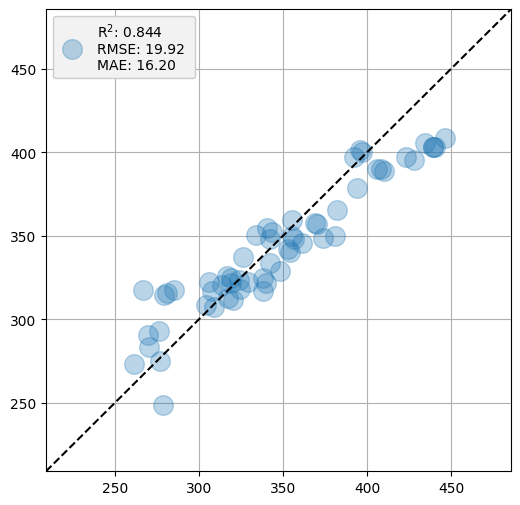

In [309]:
f, ax = plt.subplots(1,1,figsize=(6,6))
plot_scatter(ax, df.TG_exp.values, df.TG_pred.values, s=200, alpha=0.3)
#ax.set_xlim([300,450])
#ax.set_ylim([300,450])
#ax.set_xticks([300+50*i for i in range(4)])
#ax.set_yticks([300+50*i for i in range(4)])

In [564]:
for s in np.unique(df.SMILES_A):
    m_sta = np.sum(df_train[col_s].values == s, 1) != 0
    m_ssa = np.sum((df_screen[col_s].values == s) & (df_screen.TG > 390).values.reshape(-1,1), 1) != 0
    m_sea = np.sum(df[col_s].values == s, 1) != 0
    print(s)
    for des, df_, m in zip(['train','screen','exp'], [df_train, df_screen, df], [m_sta, m_ssa, m_sea]):
        if des == 'exp':
            v = df_[m].TG_exp.values
        else:
            v = df_[m].TG.values
        if np.sum(m) == 0:
            print('{:6s} : 0'.format(des))
        else:
            print('{:6s} : {:3d} / {:8.3f} / {:8.3f} / {:8.3f} / {:8.3f}'.format(
                des, np.sum(m), np.min(v), np.max(v), np.mean(v), np.std(v)
            ))
        if (np.sum(m) < 20) & (np.sum(m) > 0):
            print('\t','  '.join([f'{v:.2f}' for v in sorted(v)]))
    if (np.sum(m) < 20) & (np.sum(m) > 0):
        v = df_[m].TG_pred.values
        print('\t','  '.join([f'{v:.2f}' for v in sorted(v)]))
    print('-'*50)
    

C=C(C(=O)O)C(F)(F)F
train  : 0
screen : 107 /  390.182 /  409.438 /  395.467 /    4.341
exp    :   1 /  355.600 /  355.600 /  355.600 /    0.000
	 355.60
	 359.57
--------------------------------------------------
CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
train  :  12 /  306.550 /  415.580 /  349.938 /   35.007
	 306.55  309.65  315.95  316.35  332.29  349.63  351.13  354.14  360.79  380.43  406.77  415.58
screen :  57 /  390.032 /  408.410 /  395.127 /    4.215
exp    :   9 /  348.290 /  446.140 /  408.437 /   32.407
	 348.29  369.32  396.07  397.13  405.68  434.78  439.12  439.40  446.14
	 329.03  357.72  390.03  400.10  401.28  403.14  403.31  405.42  408.41
--------------------------------------------------
CC(=C)C(=O)OCC(C(F)(F)F)(F)F
train  :  50 /  310.050 /  405.550 /  355.894 /   23.742
screen :  27 /  390.014 /  402.653 /  394.002 /    3.234
exp    :   1 /  423.200 /  423.200 /  423.200 /    0.000
	 423.20
	 397.19
--------------------------------------------------
CC(=C)C(=O)OCC(F)(F)

In [565]:
df_all = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_221123.csv')
smiles_hightg = np.unique(df.loc[df.TG_pred > 390, col_sm].values.reshape(-1))[1:]
for s in smiles_hightg:
    print(s)
    idxs, xs = np.where((df_all[col_sm] == s).values)
    for i, x in zip(idxs[:1], xs[:1]):
        print(df_all.ID[i], 'ABCDE'[x])

CC(=C)C(=O)NC
FA-00236 B
CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
FA-00156 A
CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2
FA-00240 B
CC(=C)C(=O)OC1CC2CC1C3C2CCC3
FA-00184 B
CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C
FA-00180 B
CC(=C)C(=O)OCC(C(F)(F)F)(F)F
FA-00146 A
CC(=C)C(=O)OCC(F)(F)C(F)F
FA-00142 A
CC(=C)C(=O)OCC(F)(F)F
FA-00109 A
CC(=C)C(=O)OCCO
FA-00109 E
CC(=C)C(O)=O
FA-00109 D
COC(=O)C(C)=C
FA-00109 C
O=C1N(OC(=O)C(=C)C)C(=O)CC1
FA-00237 B


In [442]:
sm_acr = {
    'CC(=C)C(=O)NC':('N-Methylmethacrylamide','MMAA'),
    'CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F':('1,1,1,3,3,3-Hexafluoroisopropyl methacrylate','HFIPMA'),
    'CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2':( '1-Adamantyl Methacrylate','ADMMA'),
    'CC(=C)C(=O)OC1CC2CC1C3C2CCC3':('Dicyclopentanyl Methacrylate','DCPMA'),
    'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C':('Isobornyl Methacrylate','IBMA'),
    'CC(=C)C(=O)OCC(C(F)(F)F)(F)F':('2,2,3,3,3-Pentafluoropropyl methacrylate','PFPMA'),
    'CC(=C)C(=O)OCC(F)(F)C(F)F':('2,2,3,3-Tetrafluoropropyl methacrylate','TFPMA'),
    'CC(=C)C(=O)OCC(F)(F)F':('2,2,2-Trifluoroethyl methacrylate','TFEMA'),
    'CC(=C)C(=O)OCCO':('2-Hydroxyethyl methacrylate','HEMA'),
    'CC(=C)C(O)=O':('Methacrylic acid','MAA'),
    'COC(=O)C(C)=C':('Methyl methacrylate','MMA'),
    'O=C1N(OC(=O)C(=C)C)C(=O)CC1':('N-Succinimidyl Methacrylate','SMA'),
    '':('','')
}
acr_sm = {v[1]:k for k,v in sm_acr.items()}
acr_fn = {v[1]:v[0] for k,v in sm_acr.items()}
acrs = acr_sm.keys()

In [567]:
for _df in [df, df_train, df_test, df_screen]:
    for i, row in _df.iterrows():
        for x in 'ABCDE':
            s = row[f'SMILES_{x}']
            w = row[f'FR_{x}']
            if s in sm_acr.keys():
                acr = sm_acr[s][1]
            else:
                acr = s
            if w == 0:
                acr = ''
            _df.loc[i, f'ACR_{x}'] = acr
col_ac = [f'ACR_{x}' for x in 'ABCDE']
df[col_ac + col_fr + ['TG_pred', 'TG_exp']]

,ACR_A,ACR_B,ACR_C,ACR_D,ACR_E,FR_A,FR_B,FR_C,FR_D,FR_E,TG_pred,TG_exp
57742,CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,C=CC(=O)OCCOc1ccccc1,MMAA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,HEMA,0.2,0.2,0.2,0.2,0.2,321.614568,319.23
57796,CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,C=CC(=O)OCCOc1ccccc1,CC(=C)C(=O)OC(C)(C)C,CCCCCCCCCCCCCCCCCCOC(=O)C=C,HEMA,0.2,0.2,0.2,0.2,0.2,315.596227,281.15
58800,CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,MMAA,CC(=O)CC(=O)OCCOC(=O)C(C)=C,CCCCCCCCCCCCCCCCCCOC(=O)C=C,HEMA,0.2,0.2,0.2,0.2,0.2,322.040612,305.97
73278,CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,CCOC(=O)C(C)=C,,HEMA,0.4,0.2,0.2,0.0,0.2,308.813165,304.33
127318,CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,CCCCC(CC)COC(=O)C=C,CCCCCCOC(=O)C(C)=C,,HEMA,0.2,0.2,0.4,0.0,0.2,317.423864,285.18
122193,CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,C=CC(=O)OCCOc1ccccc1,CC(=C)C(=O)Oc1ccccc1,CCCCCCCCCCCCCCCCCCOC(=O)C=C,HEMA,0.2,0.2,0.2,0.2,0.2,317.775907,266.90
154907,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCO...,CCCCCCCCCCCCCCCCCCOC(=O)C=C,CC(=O)CC(=O)OCCOC(=O)C(C)=C,,HEMA,0.2,0.2,0.4,0.0,0.2,314.824154,279.06
164837,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C,CC(=C)C(=O)OC1CCCCC1,CCCCCCCCCCCCCCCCCCOC(=O)C=C,,HEMA,0.4,0.2,0.2,0.0,0.2,293.203049,276.35
119275,CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,,,,HEMA,0.8,0.0,0.0,0.0,0.2,311.798458,320.08
192675,FC(F)(F)COC(=O)C=C,,,,HEMA,0.8,0.0,0.0,0.0,0.2,290.857432,269.84


0.9212113409487197 21


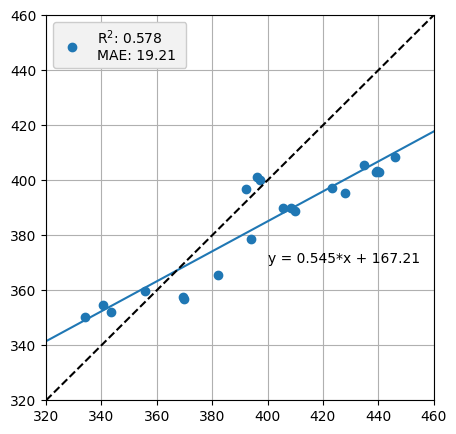

In [554]:
f, ax = plt.subplots(1,1,figsize=(5,5))
m = (df.TG_pred > 350)
t = df.TG_exp[m].values
p = df.TG_pred[m].values
plot_scatter(ax, t, p, metrics=['R2','MAE'])
print(np.corrcoef(t, p)[0,1], m.sum())

from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(t.reshape(-1,1), p)
x = np.linspace(320,460,100)
y = LR.predict(x.reshape(-1,1))
ax.plot(x,y)
a, b = LR.coef_[0], LR.predict([[0]])[0]
p2 = (p - b) / a
#plot_scatter(ax, t, p2)
ax.text(400, 370, f'y = {a:.3f}*x + {b:.2f}')
ax.set_xlim([320, 460])
ax.set_ylim([320, 460])
f.savefig('../../figs/output.exp.pdf')


In [575]:
df.loc[(df.TG_exp > 430), col_ac + ['TG_pred', 'TG_exp']] 

,ACR_A,ACR_B,ACR_C,ACR_D,ACR_E,TG_pred,TG_exp
41420,HFIPMA,ADMMA,MAA,SMA,HEMA,408.409668,446.14
96470,TFEMA,ADMMA,MAA,SMA,HEMA,402.984204,440.32
40248,HFIPMA,MMAA,ADMMA,MAA,HEMA,405.418906,434.78
41248,HFIPMA,ADMMA,DCPMA,MAA,HEMA,403.305782,439.40
41271,HFIPMA,ADMMA,IBMA,MAA,HEMA,403.138853,439.12


In [428]:
ss, cs = np.unique(df_train[col_sm].values.reshape(-1), return_counts=True)
o = np.argsort(cs)[::-1][1:]
ss, cs = ss[o], cs[o]
ss = [s if s not in sm_acr.keys() else sm_acr[s][1] for s in ss]

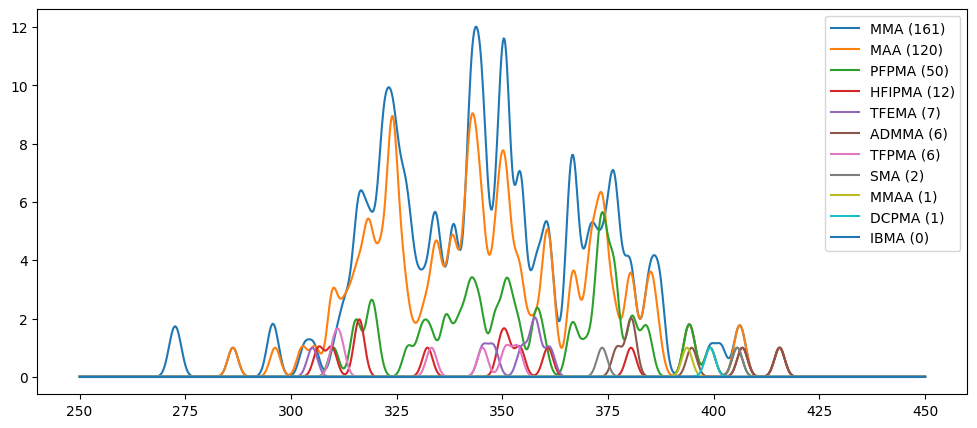

In [455]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

f, ax = plt.subplots(1,1,figsize=(12, 5))
for acr in sorted(acrs, key=lambda x: (df_train[col_ac] == x).values.sum(), reverse=True):
    if acr == '': continue
    if acr == 'HEMA': continue
    m = (df_train[col_ac] == acr).values.sum(1) != 0
    val = df_train.TG.values[m]
    g1 = gaussian_kernel(val, 3)
    x = np.linspace(250, 450, 1000)
    y = g1(x)
    y[y < 1e-3] = 0
    ax.plot(x, y, label=f'{acr} ({m.sum()})')
ax.legend(loc='upper right')

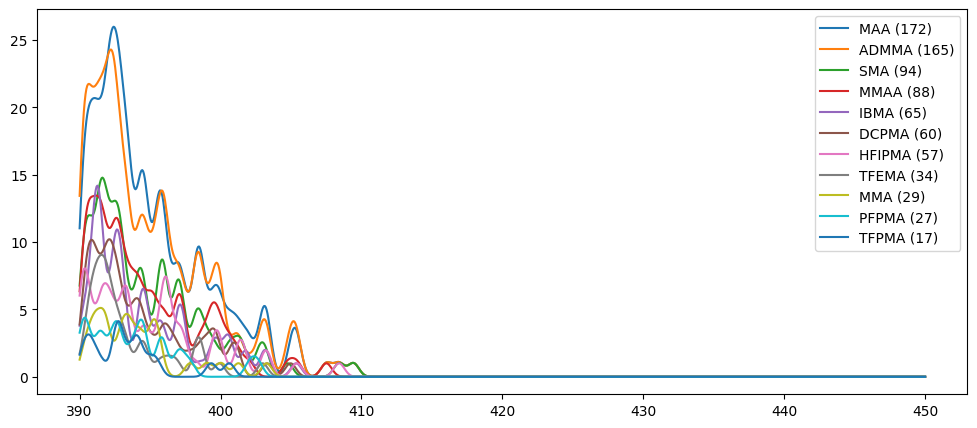

In [466]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

f, ax = plt.subplots(1,1,figsize=(12, 5))
m0 = df_screen.TG > 390
for acr in sorted(acrs, key=lambda x: (df_screen.loc[m0, col_ac] == x).values.sum(), reverse=True):
    if acr == '': continue
    if acr == 'HEMA': continue
    m = (df_screen.loc[m0, col_ac] == acr).values.sum(1) != 0
    val = df_screen.loc[m0, 'TG'].values[m]
    g1 = gaussian_kernel(val, 0.3)
    x = np.linspace(390, 450, 1000)
    y = g1(x)
    y[y < 1e-3] = 0
    ax.plot(x, y, label=f'{acr} ({m.sum()})')
ax.legend(loc='upper right')

In [469]:
df_train.loc[(df_train[col_ac] == 'TFEMA').sum(1).astype(bool), col_ac + col_fr + ['TG']]

,ACR_A,ACR_B,ACR_C,ACR_D,ACR_E,FR_A,FR_B,FR_C,FR_D,FR_E,TG
0,TFEMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA,0.2,0.1,0.4,0.1,0.2,361.18
1,TFEMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA,0.4,0.1,0.2,0.1,0.2,354.64
30,TFEMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,,MAA,HEMA,0.6,0.1,0.0,0.1,0.2,347.94
135,TFEMA,,,,HEMA,0.8,0.0,0.0,0.0,0.2,345.34
199,TFEMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,,,HEMA,0.4,0.4,0.0,0.0,0.2,357.55
203,TFEMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,,,CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O,0.4,0.4,0.0,0.0,0.2,305.05
230,PFPMA,TFEMA,MMA,,HEMA,0.2,0.2,0.4,0.0,0.2,357.92


In [481]:
from sklearn.metrics import r2_score, mean_absolute_error
a, b = df_hightg.loc[df_hightg['ACR_A'] == 'HFIPMA', 'TG_exp'].values, df_hightg.loc[df_hightg['ACR_A'] == 'HFIPMA', 'TG_pred'].values
a, b = df_hightg.TG_exp.values, df_hightg.TG_pred.values
r2_score(a, b), mean_absolute_error(a, b), np.corrcoef(a, b)[0,1]

(-0.9965950575296598, 23.975772816051133, 0.594530103584518)

In [487]:
df_test[col_ac]

,ACR_A,ACR_B,ACR_C,ACR_D,ACR_E
0,TFPMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA
1,PFPMA,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA
2,CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)F,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA
3,CC(=C)C(=O)OCC(F)(F)[C@H](F)C(F)(F)F,CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C,MMA,MAA,HEMA
4,PFPMA,IBMA,,MAA,HEMA
5,PFPMA,IBMA,MMA,MAA,HEMA
6,PFPMA,IBMA,MMA,MAA,HEMA
7,PFPMA,DCPMA,,MAA,HEMA
8,PFPMA,DCPMA,MMA,MAA,HEMA
9,PFPMA,CC(=C)C(=O)OCc1ccccc1,,MAA,HEMA
